# UBC CPSC 340 lecture 30 demo

Stochastic gradient, dropout

In [2]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline

### Stochastic gradient descent demo

Here, we'll generate random data in 1-D that roughly follows a linear trend. Then, we'll fit a linear model (just one parameter, $w$) using stochastic gradient descent. At each iteration, the randomly selected examples are shown with red stars. 

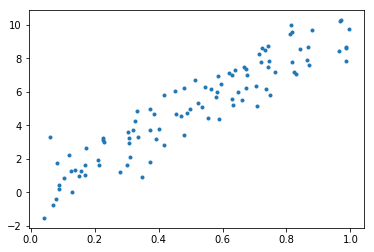

In [36]:
# generate random data
N = 100
x = npr.rand(N)
y = 10*x + npr.randn(N)
# y[x<0.1] += 10*npr.rand(sum(x<0.1)) # add some outliers

# plot the points
plt.plot(x,y,'.')

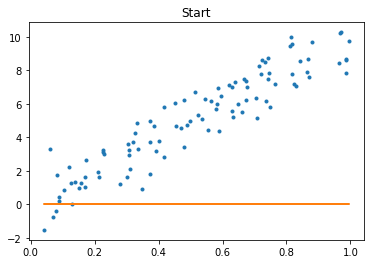

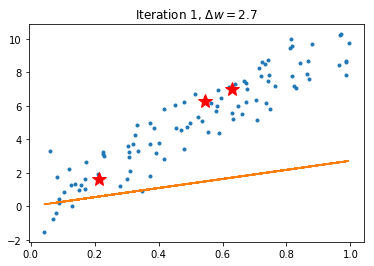

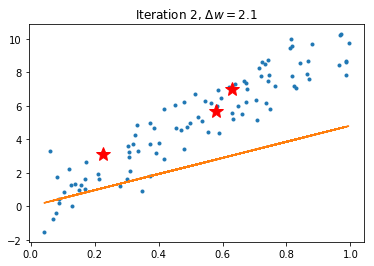

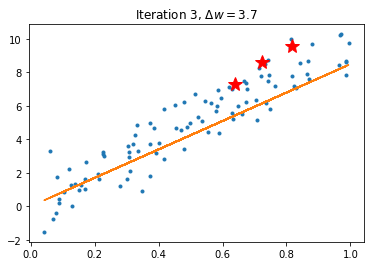

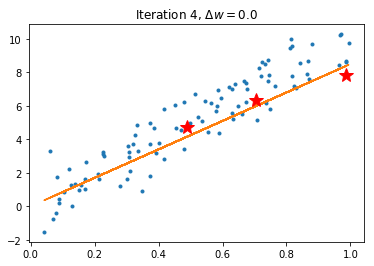

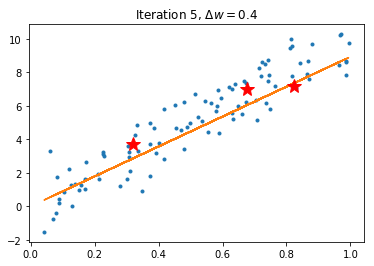

w = 8.931724


In [37]:

w = 0
alpha = 1
Nsteps = 5
minibatch_size = 3

# f(w) = sum (wx-y)^2
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x)
plt.title("Start")

for t in range(Nsteps):
    
    i = np.random.choice(N,size=minibatch_size,replace=False) 

    dfdw = np.mean(x[i]*(w*x[i]-y[i]))
    w -= alpha*dfdw
    
    plt.figure()
    plt.plot(x,y,'.')
    plt.plot(x,w*x)
    plt.plot(x[i],y[i],'*',color='red',markersize=15)
    plt.title("Iteration %d, $\Delta w=%.1f$" % (t+1, -alpha*dfdw))
    plt.show()

print("w = %f" % w)

### Demo: RBF features fitting with dropout

Here, we will show that dropout regularizes a 1-d regression model.

#### generate some random data in 1-d

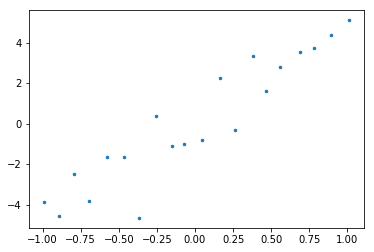

In [40]:
N = 20
X = np.linspace(-1,1,N)+npr.randn(N)*0.01
X=X[:,None]
y = npr.randn(N,1) + X*5

plt.plot(X,y,'.',markersize=5)

#### try fitting with RBF features

[ 20.67134475]
Loss = 0.000000


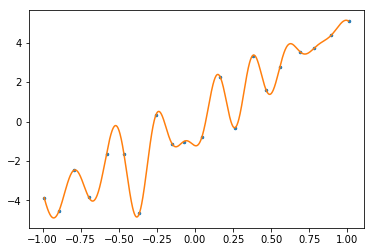

In [41]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

class RBF_features():
    def __init__(self, sigma=1):
        self.sigma=sigma

    def fit(self,Xtrain):
        self.Xtrain = Xtrain
    
    def transform(self, Xtest):
        return np.exp(-0.5*euclidean_dist_squared(Xtest,self.Xtrain)/self.sigma**2)

    
rbf = RBF_features(sigma=0.1)
rbf.fit(X)

grid = np.linspace(min(X),max(X),1000)[:,None]
grid_Z = rbf.transform(grid)

Z = rbf.transform(X)
w = npla.solve(Z.T@Z,Z.T@y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)



The above model looks like it overfits. We now try to combat this with regularization.

#### add L2-regularization

(20, 20)
[ 2.18613848]
Loss = 26.377062


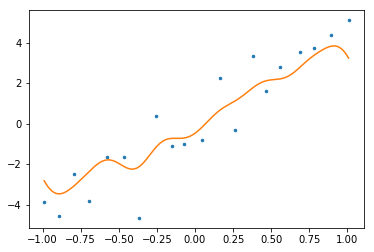

In [42]:
# add regularization
print(Z.shape)
d = Z.shape[1]

reg_strength = 1
w = npla.solve(Z.T @ Z + reg_strength*np.eye(d), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)

(above) regularization seems to work

#### re-do unregularized problem, but with gradient descent instead of normal eqn's

[ 20.67131647]
Loss = 0.000000
[[  1.54361594e-16]]


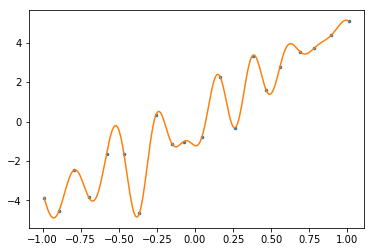

In [47]:
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 100000

reg_strength = 0

ZTZ = Z.T@Z + reg_strength*np.eye(d)

for t in range(Nsteps):
    
    dLdw = (ZTZ@w-Z.T@y)/N
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: looks the same as with normal equations, OK good.

#### now we use dropout. At each iteration we randomly select what to drop.

you can drop the activations _or_ the weights

- dropping the weights is more intuitive with respect to the idea of "averaging different architectures"
- the two approaches are basically equivalent. But the implementations are a bit different.
- we'll do both implementations below.

First, dropping the weights

[ 3.70597416]
Loss = 10.046302
[[ 0.42030122]]


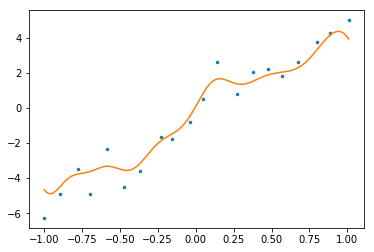

In [30]:
# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
ZTZ = Z.T@Z
dropout_prob = 0.25

for t in range(Nsteps):
    

    mask = np.random.rand(d,1) > dropout_prob
    w_drop = w * mask     # dropping the weights

    dLdw = (ZTZ@w_drop-Z.T@y)/N
    w -= alpha*dLdw*mask
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: dropout seems to do what we expect! That is great. You can play around with the dropout probability to see how it behaves.

** note the line of code where we scale $w$ at the end **

- we need to "make testing like training" but we want to use all the weights during testing
- so we just scale things down proportionally since we're using more weights than usual

(below) We can also drop the activations instead of the weights, but now we don't precompute $Z^TZ$:

[ 3.5749606]
Loss = 10.650053
[[ 0.02153788]]


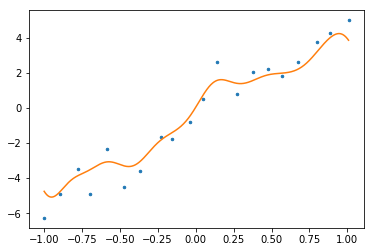

In [26]:
# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
dropout_prob = 0.25

for t in range(Nsteps):
    
    # can dropout the Z's or the w's probably
    mask = np.random.rand(*Z.shape) > dropout_prob
    Z_drop = Z * mask

    dLdw = (Z_drop.T@Z_drop@w-Z_drop.T@y)/N
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)